In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import mat73
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

from scipy.signal import find_peaks
from sklearn.metrics import r2_score
import psutil
import os
import time

In [ ]:
wandb.login()
# run = wandb.init(project="master-multicomponent-mri", name="unet-baseline-fullpatch")
run = wandb.init(project="master-multicomponent-mri", name="unet-baseline-fullpatch-att")

In [ ]:
data = mat73.loadmat('../../data/training_data_T1_3D_9x9x32x47932_noise0.05.mat')
input_noisy_np = data['input_noisy']
input_clean_np = data['input']
ref_np = data['ref']

print("Shape of input data:", input_noisy_np.shape)
print("Shape of reference data:", ref_np.shape)

Shape of input data: (9, 9, 8, 47932)
Shape of reference data: (9, 9, 32, 47932)


In [24]:
nan_count_input_noisy_before = np.isnan(input_noisy_np).sum()
nan_count_ref_before = np.isnan(ref_np).sum()
print(f"NaN count in input_noisy before handling: {nan_count_input_noisy_before}")
print(f"NaN count in ref before handling: {nan_count_ref_before}")

NaN count in input_noisy before handling: 1635840
NaN count in ref before handling: 0


In [25]:
input_noisy_np = np.nan_to_num(input_noisy_np, nan=0.0)
nan_count_input_noisy_after = np.isnan(input_noisy_np).sum()
print(f"NaN count in input_noisy after handling: {nan_count_input_noisy_after}")

NaN count in input_noisy after handling: 0


In [26]:
class T1PatchDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]

In [27]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//8, kernel_size=1),
            nn.BatchNorm2d(in_channels//8),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels//8, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

In [28]:
class DoubleConvWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )
        self.attention = SpatialAttention(out_channels)

    def forward(self, x):
        x = self.double_conv(x)
        x = self.attention(x)
        return x

In [29]:
class UNetWithAttention(nn.Module):
    def __init__(self):
        super(UNetWithAttention, self).__init__()
        
        # Encoder path
        self.conv1 = DoubleConvWithAttention(8, 64)
        self.pool1 = nn.MaxPool2d(2, padding=1)
        self.conv2 = DoubleConvWithAttention(64, 128)
        
        # Bridge
        self.bridge_conv = DoubleConvWithAttention(128, 256)
        
        # Decoder path
        self.upconv = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConvWithAttention(192, 128)  # 192 = 128 + 64 (skip connection)
        
        # Final convolutions with attention
        self.final_conv = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            SpatialAttention(64),
            nn.Conv2d(64, 32, kernel_size=1)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoding path
        conv1 = self.conv1(x)           # [batch, 64, 9, 9]
        x = self.pool1(conv1)           # [batch, 64, 5, 5]
        conv2 = self.conv2(x)           # [batch, 128, 5, 5]
        
        # Bridge
        x = self.bridge_conv(conv2)     # [batch, 256, 5, 5]
        
        # Decoding path
        x = self.upconv(x)              # [batch, 128, 10, 10]
        x = x[:, :, :9, :9]            # [batch, 128, 9, 9]
        x = torch.cat([x, conv1], dim=1)  # [batch, 192, 9, 9]
        x = self.conv3(x)               # [batch, 128, 9, 9]
        
        # Final convolutions
        x = self.final_conv(x)          # [batch, 32, 9, 9]
        
        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-6, path='saved_models/best_unet_model_attention.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [ ]:
# Transpose the input and reference data to be (N, C, H, W) format
input_noisy_torch = np.transpose(input_noisy_np, (3, 2, 0, 1))
ref_torch = np.transpose(ref_np, (3, 2, 0, 1))

input_noisy_torch = torch.tensor(input_noisy_torch, dtype=torch.float32)
ref_torch = torch.tensor(ref_torch, dtype=torch.float32)

In [32]:
input_mean = input_noisy_torch.mean()
input_std = input_noisy_torch.std()
input_noisy_torch = (input_noisy_torch - input_mean) / input_std

In [ ]:
# Create Dataset
dataset = T1PatchDataset(input_noisy_torch, ref_torch)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetWithAttention().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=8, path='best_unet_model.pt')

num_epochs = 200

d:\Proton Drive\My files\Schule\Master\Masterarbeit\project\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [35]:
# Log configuration
wandb.config.update({
    "learning_rate": 0.001,
    "batch_size": batch_size,
    "epochs": num_epochs,
    "architecture": "UNet",
    "optimizer": "Adam",
    "loss_function": "MSELoss",
    "scheduler": "ReduceLROnPlateau",
    "early_stopping_patience": 8
})

In [36]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Training')
    
    for inputs, targets in progress_bar_train:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
        progress_bar_train.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    progress_bar_val = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Validation')
    
    with torch.no_grad():
        for inputs, targets in progress_bar_val:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            progress_bar_val.set_postfix({'loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Early stopping
    early_stopping(avg_val_loss, model)

    # Logging
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": current_lr
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, LR: {current_lr}')

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("Training finished")

Epoch [1/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 165.25it/s, loss=0.00311]


Epoch [1/200], Train Loss: 0.00755484528761978, Val Loss: 0.005560540044680238, LR: 0.001


Epoch [2/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 182.75it/s, loss=0.00438]


Epoch [2/200], Train Loss: 0.0027585439663380383, Val Loss: 0.005039022085256874, LR: 0.001


Epoch [3/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 166.97it/s, loss=0.00272]


EarlyStopping counter: 1 out of 8
Epoch [3/200], Train Loss: 0.002498810812054823, Val Loss: 0.014666141003059845, LR: 0.001


Epoch [4/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 161.83it/s, loss=0.0176] 


EarlyStopping counter: 2 out of 8
Epoch [4/200], Train Loss: 0.0023687165533192458, Val Loss: 0.01215281598114719, LR: 0.001


Epoch [5/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 142.18it/s, loss=0.00309]


Epoch [5/200], Train Loss: 0.0022861299729750803, Val Loss: 0.002927093342101822, LR: 0.001


Epoch [6/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 162.21it/s, loss=0.0023] 


Epoch [6/200], Train Loss: 0.002226717791054398, Val Loss: 0.0023482904008900124, LR: 0.001


Epoch [7/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 182.41it/s, loss=0.0318] 


EarlyStopping counter: 1 out of 8
Epoch [7/200], Train Loss: 0.0021822453825734557, Val Loss: 0.016949738559002676, LR: 0.001


Epoch [8/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 167.14it/s, loss=0.0165] 


EarlyStopping counter: 2 out of 8
Epoch [8/200], Train Loss: 0.0021318574926893537, Val Loss: 0.011912158632961412, LR: 0.001


Epoch [9/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 167.09it/s, loss=0.00247]


EarlyStopping counter: 3 out of 8
Epoch [9/200], Train Loss: 0.0021885498554911464, Val Loss: 0.00321111340696613, LR: 0.001


Epoch [10/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 176.66it/s, loss=0.00215]


Epoch [10/200], Train Loss: 0.0020856531866593284, Val Loss: 0.0020531054539605974, LR: 0.001


Epoch [11/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 172.66it/s, loss=0.00221]


EarlyStopping counter: 1 out of 8
Epoch [11/200], Train Loss: 0.002040878863966403, Val Loss: 0.007019748361005137, LR: 0.001


Epoch [12/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 158.57it/s, loss=0.00224]


EarlyStopping counter: 2 out of 8
Epoch [12/200], Train Loss: 0.0020189825645259892, Val Loss: 0.002133071511828651, LR: 0.001


Epoch [13/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 164.48it/s, loss=0.00219]


EarlyStopping counter: 3 out of 8
Epoch [13/200], Train Loss: 0.001999912336662722, Val Loss: 0.0022210154752247036, LR: 0.001


Epoch [14/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 174.38it/s, loss=0.00259]


EarlyStopping counter: 4 out of 8
Epoch [14/200], Train Loss: 0.002198608416171434, Val Loss: 0.0025675571469279627, LR: 0.001


Epoch [15/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 165.55it/s, loss=0.0115] 


EarlyStopping counter: 5 out of 8
Epoch [15/200], Train Loss: 0.0021294719634655243, Val Loss: 0.008642338369973003, LR: 0.001


Epoch [16/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 177.14it/s, loss=0.00215]


Epoch [16/200], Train Loss: 0.0020898162944164747, Val Loss: 0.0019491899215305845, LR: 0.001


Epoch [17/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 175.72it/s, loss=0.00218]


EarlyStopping counter: 1 out of 8
Epoch [17/200], Train Loss: 0.001999158221296966, Val Loss: 0.0020326923586738606, LR: 0.001


Epoch [18/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 171.80it/s, loss=0.00217]


EarlyStopping counter: 2 out of 8
Epoch [18/200], Train Loss: 0.0019699446191467967, Val Loss: 0.002028997140781333, LR: 0.001


Epoch [19/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 169.96it/s, loss=0.0022] 


EarlyStopping counter: 3 out of 8
Epoch [19/200], Train Loss: 0.0019334918120875954, Val Loss: 0.0019711271681201953, LR: 0.001


Epoch [20/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 163.05it/s, loss=0.00213]


EarlyStopping counter: 4 out of 8
Epoch [20/200], Train Loss: 0.0019182068994268776, Val Loss: 0.00206067013166224, LR: 0.001


Epoch [21/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 167.02it/s, loss=0.00213]


EarlyStopping counter: 5 out of 8
Epoch [21/200], Train Loss: 0.001897374068503268, Val Loss: 0.001975197025264303, LR: 0.001


Epoch [22/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 159.78it/s, loss=0.00218]


EarlyStopping counter: 6 out of 8
Epoch [22/200], Train Loss: 0.0018821606585212674, Val Loss: 0.0020432325188691415, LR: 0.0005


Epoch [23/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 172.87it/s, loss=0.00208]


Epoch [23/200], Train Loss: 0.001811603790653559, Val Loss: 0.0018498681757288674, LR: 0.0005


Epoch [24/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 163.16it/s, loss=0.00196]


EarlyStopping counter: 1 out of 8
Epoch [24/200], Train Loss: 0.0017962907448721428, Val Loss: 0.0019241472411279878, LR: 0.0005


Epoch [25/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 153.18it/s, loss=0.00202]


Epoch [25/200], Train Loss: 0.0017952659289585426, Val Loss: 0.0018165908164034287, LR: 0.0005


Epoch [26/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 158.51it/s, loss=0.00191]


EarlyStopping counter: 1 out of 8
Epoch [26/200], Train Loss: 0.001786619852646254, Val Loss: 0.001904206812226524, LR: 0.0005


Epoch [27/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 174.74it/s, loss=0.00197]


EarlyStopping counter: 2 out of 8
Epoch [27/200], Train Loss: 0.0017768441072742766, Val Loss: 0.0027270143991336227, LR: 0.0005


Epoch [28/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 161.12it/s, loss=0.00214]


EarlyStopping counter: 3 out of 8
Epoch [28/200], Train Loss: 0.001765745745700163, Val Loss: 0.001947946777412047, LR: 0.0005


Epoch [29/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 167.74it/s, loss=0.00199]


EarlyStopping counter: 4 out of 8
Epoch [29/200], Train Loss: 0.0017662794408776488, Val Loss: 0.0018369992178243896, LR: 0.0005


Epoch [30/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 172.06it/s, loss=0.00196]


Epoch [30/200], Train Loss: 0.0017467934087229272, Val Loss: 0.0018155770748853684, LR: 0.0005


Epoch [31/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 165.26it/s, loss=0.002]  


EarlyStopping counter: 1 out of 8
Epoch [31/200], Train Loss: 0.0017370893759652971, Val Loss: 0.0019174981505299608, LR: 0.0005


Epoch [32/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 160.42it/s, loss=0.00201]


EarlyStopping counter: 2 out of 8
Epoch [32/200], Train Loss: 0.001733221501344815, Val Loss: 0.0018324535378875832, LR: 0.0005


Epoch [33/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 164.56it/s, loss=0.00193]


EarlyStopping counter: 3 out of 8
Epoch [33/200], Train Loss: 0.0017237903849066545, Val Loss: 0.0023014913584726553, LR: 0.0005


Epoch [34/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 170.00it/s, loss=0.00199]


EarlyStopping counter: 4 out of 8
Epoch [34/200], Train Loss: 0.0017158503087315088, Val Loss: 0.0020663760540386043, LR: 0.0005


Epoch [35/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 153.44it/s, loss=0.0019] 


EarlyStopping counter: 5 out of 8
Epoch [35/200], Train Loss: 0.0017081895018539702, Val Loss: 0.0018303627450950443, LR: 0.0005


Epoch [36/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 156.54it/s, loss=0.00192]


Epoch [36/200], Train Loss: 0.0017017635392645996, Val Loss: 0.0017942376349431772, LR: 0.0005


Epoch [37/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 174.56it/s, loss=0.00192]


Epoch [37/200], Train Loss: 0.0016957519828186681, Val Loss: 0.0017833954577023785, LR: 0.0005


Epoch [38/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 170.54it/s, loss=0.00195]


EarlyStopping counter: 1 out of 8
Epoch [38/200], Train Loss: 0.0016913956430895875, Val Loss: 0.0018181717170712849, LR: 0.0005


Epoch [39/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 177.28it/s, loss=0.00185]


EarlyStopping counter: 2 out of 8
Epoch [39/200], Train Loss: 0.001677927995333448, Val Loss: 0.0019416417616109052, LR: 0.0005


Epoch [40/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 175.55it/s, loss=0.00201]


EarlyStopping counter: 3 out of 8
Epoch [40/200], Train Loss: 0.001672343390334087, Val Loss: 0.001809277383921047, LR: 0.0005


Epoch [41/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 173.82it/s, loss=0.00206]


EarlyStopping counter: 4 out of 8
Epoch [41/200], Train Loss: 0.0016835102700861171, Val Loss: 0.001984630192940434, LR: 0.0005


Epoch [42/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 171.80it/s, loss=0.00192]


EarlyStopping counter: 5 out of 8
Epoch [42/200], Train Loss: 0.0016596758926364903, Val Loss: 0.0018170626383895675, LR: 0.0005


Epoch [43/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 173.73it/s, loss=0.00188]


EarlyStopping counter: 6 out of 8
Epoch [43/200], Train Loss: 0.0016523181416171913, Val Loss: 0.0018064410355873406, LR: 0.00025


Epoch [44/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 178.40it/s, loss=0.00187]


Epoch [44/200], Train Loss: 0.001603321925116082, Val Loss: 0.0017494080308824778, LR: 0.00025


Epoch [45/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 184.03it/s, loss=0.0019] 


EarlyStopping counter: 1 out of 8
Epoch [45/200], Train Loss: 0.0015899157244712114, Val Loss: 0.0017522602132521569, LR: 0.00025


Epoch [46/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 170.32it/s, loss=0.00185]


EarlyStopping counter: 2 out of 8
Epoch [46/200], Train Loss: 0.0015834492101566866, Val Loss: 0.0017890238971449434, LR: 0.00025


Epoch [47/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 174.89it/s, loss=0.00188]


EarlyStopping counter: 3 out of 8
Epoch [47/200], Train Loss: 0.0015798358687122043, Val Loss: 0.0017512093065306545, LR: 0.00025


Epoch [48/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 174.61it/s, loss=0.00187]


EarlyStopping counter: 4 out of 8
Epoch [48/200], Train Loss: 0.001567153301439248, Val Loss: 0.0017736882227472961, LR: 0.00025


Epoch [49/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 171.82it/s, loss=0.0019] 


EarlyStopping counter: 5 out of 8
Epoch [49/200], Train Loss: 0.0015641402306694847, Val Loss: 0.001774993313010782, LR: 0.00025


Epoch [50/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 173.07it/s, loss=0.0019] 


EarlyStopping counter: 6 out of 8
Epoch [50/200], Train Loss: 0.001552995124948211, Val Loss: 0.0018297204088109234, LR: 0.000125


Epoch [51/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 173.08it/s, loss=0.00185]


EarlyStopping counter: 7 out of 8
Epoch [51/200], Train Loss: 0.0015191729395883158, Val Loss: 0.0018504632636904717, LR: 0.000125


Epoch [52/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 171.06it/s, loss=0.00183]

EarlyStopping counter: 8 out of 8
Epoch [52/200], Train Loss: 0.0015137457149103284, Val Loss: 0.0017594647671406469, LR: 0.000125
Early stopping triggered
Training finished


In [ ]:
def calculate_psnr(target, prediction):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = np.mean((target - prediction) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(target)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_peak_metrics_patch(target, prediction, prominence=0.1):
    """Calculate peak detection accuracy for full patch predictions"""
    peak_metrics = {'true_peaks': 0, 'predicted_peaks': 0, 'matching_peaks': 0}
    
    # Iterate over each voxel in the patch
    batch_size, num_points, height, width = target.shape
    
    for b in range(batch_size):
        for h in range(height):
            for w in range(width):
                # Get spectrum for current voxel
                true_spectrum = target[b, :, h, w]
                pred_spectrum = prediction[b, :, h, w]
                
                # Find peaks
                true_peaks, _ = find_peaks(true_spectrum, prominence=prominence)
                pred_peaks, _ = find_peaks(pred_spectrum, prominence=prominence)
                
                # Count matching peaks
                matches = 0
                for tp in true_peaks:
                    for pp in pred_peaks:
                        if abs(tp - pp) <= 1:
                            matches += 1
                            break
                
                peak_metrics['true_peaks'] += len(true_peaks)
                peak_metrics['predicted_peaks'] += len(pred_peaks)
                peak_metrics['matching_peaks'] += matches
    
    return peak_metrics

def measure_inference_time(model, input_tensor, device, num_iterations=100):
    """Measure average inference time"""
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_tensor.to(device))
    end_time = time.time()
    return (end_time - start_time) / num_iterations

def count_parameters(model):
    """Count number of trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_memory_usage():
    """Measure current memory usage"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

def calculate_spatial_consistency(targets, predictions, window_size=3):
    """Calculate spatial consistency metric with proper handling of constant patches"""
    batch_size, num_points, height, width = targets.shape
    consistency_scores = []
    
    # Calculate local spatial correlation for each patch
    for b in range(min(batch_size, 100)):  # Limit to 100 samples for efficiency
        for t in range(num_points):
            true_patch = targets[b, t]
            pred_patch = predictions[b, t]
            
            # Skip if either patch is constant
            if np.std(true_patch) == 0 or np.std(pred_patch) == 0:
                continue
                
            # Calculate local spatial correlation
            try:
                correlation = np.corrcoef(true_patch.flatten(), pred_patch.flatten())[0, 1]
                if not np.isnan(correlation):
                    consistency_scores.append(correlation)
            except:
                continue
    
    # Return mean if we have scores, otherwise return 0
    return np.mean(consistency_scores) if consistency_scores else 0.0


def evaluate_model_metrics(model, val_loader, device):
    """Evaluate all model metrics for patch-based models"""
    model.eval()
    metrics = {}
    
    # Get sample input for inference time measurement
    sample_input, _ = next(iter(val_loader))
    metrics['inference_time'] = measure_inference_time(model, sample_input, device)
    
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            # Convert to numpy for metric calculation
            targets_np = targets.cpu().numpy()
            outputs_np = outputs.cpu().numpy()
            
            all_targets.append(targets_np)
            all_predictions.append(outputs_np)
    
    # Concatenate all batches
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    
    # Calculate metrics
    metrics['mse'] = np.mean((all_targets - all_predictions) ** 2)
    metrics['mae'] = np.mean(np.abs(all_targets - all_predictions))
    metrics['psnr'] = calculate_psnr(all_targets, all_predictions)
    
    # Calculate R² score for each spatial position
    r2_scores = []
    batch_size, num_points, height, width = all_targets.shape
    for h in range(height):
        for w in range(width):
            true_spectra = all_targets[:, :, h, w].reshape(-1)
            pred_spectra = all_predictions[:, :, h, w].reshape(-1)
            r2_scores.append(r2_score(true_spectra, pred_spectra))
    metrics['r2_score'] = np.mean(r2_scores)
    
    # Calculate peak metrics for patches
    metrics['peak_metrics'] = calculate_peak_metrics_patch(all_targets, all_predictions)
    
    # System metrics
    metrics['memory_usage'] = measure_memory_usage()
    metrics['num_parameters'] = count_parameters(model)
    
    # Add spatial metrics
    metrics['spatial_consistency'] = calculate_spatial_consistency(all_targets, all_predictions)
    
    return metrics

In [ ]:
model.eval()
final_metrics = evaluate_model_metrics(model, val_loader, device)

wandb.log({
    "final_mse": final_metrics['mse'],
    "final_mae": final_metrics['mae'],
    "final_psnr": final_metrics['psnr'],
    "final_r2_score": final_metrics['r2_score'],
    "peak_detection_accuracy": final_metrics['peak_metrics']['matching_peaks'] / 
                             final_metrics['peak_metrics']['true_peaks'],
    "inference_time_ms": final_metrics['inference_time'] * 1000,
    "memory_usage_mb": final_metrics['memory_usage'],
    "model_parameters": final_metrics['num_parameters']
})

print("\nFinal Model Evaluation:")
print(f"MSE: {final_metrics['mse']:.6f}")
print(f"MAE: {final_metrics['mae']:.6f}")
print(f"PSNR: {final_metrics['psnr']:.2f} dB")
print(f"R² Score: {final_metrics['r2_score']:.4f}")
print(f"Peak Detection Accuracy: {final_metrics['peak_metrics']['matching_peaks'] / final_metrics['peak_metrics']['true_peaks']:.2%}")
print(f"Average Inference Time: {final_metrics['inference_time']*1000:.2f} ms")
print(f"Memory Usage: {final_metrics['memory_usage']:.1f} MB")
print(f"Number of Parameters: {final_metrics['num_parameters']:,}")


Final Model Evaluation:
MSE: 0.001759
MAE: 0.021584
PSNR: 27.53 dB
R² Score: 0.5711
Peak Detection Accuracy: 46.71%
Average Inference Time: 3.65 ms
Memory Usage: 2797.7 MB
Number of Parameters: 1,754,192


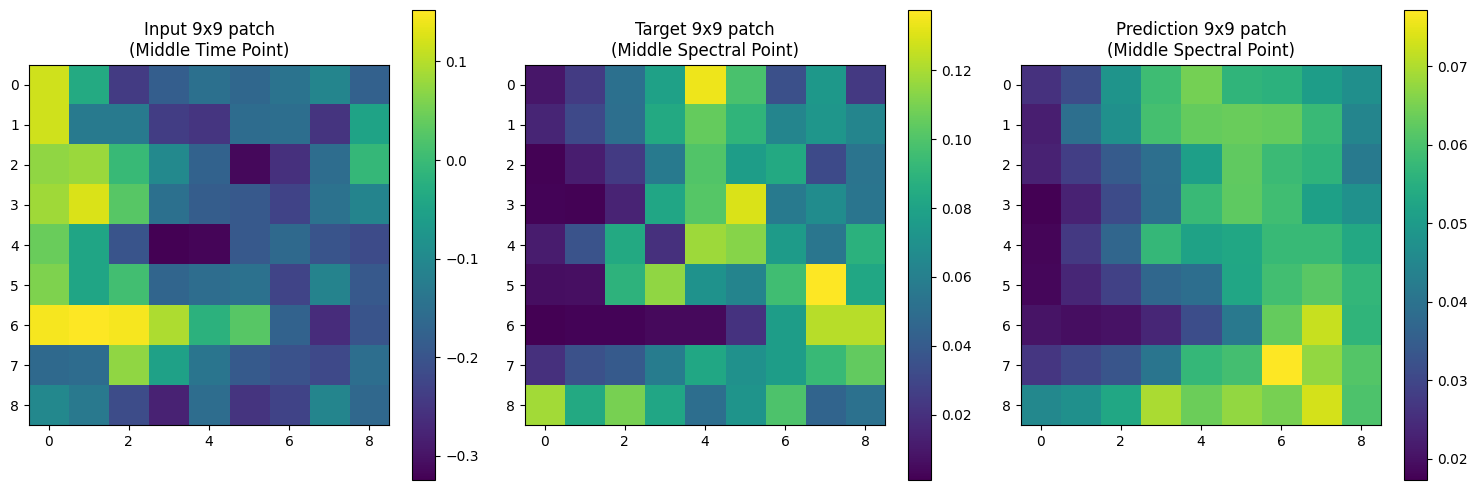

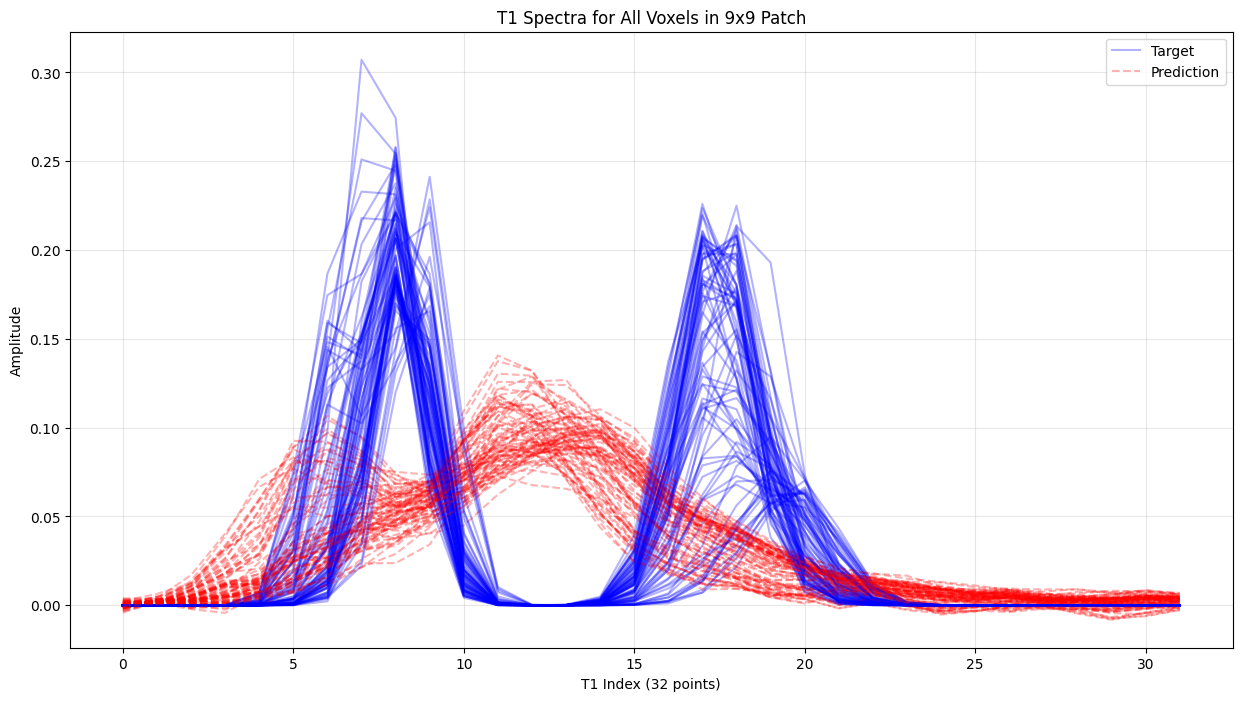

Full 9x9 patch MSE: 0.003395
Full 9x9 patch MAE: 0.037353

Mean Voxel MSE: 0.003395
Std Voxel MSE: 0.000584
Min Voxel MSE: 0.002072
Max Voxel MSE: 0.005061


In [ ]:
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

with torch.no_grad():
    outputs = model(inputs)

inputs = inputs.cpu().numpy()
targets = targets.cpu().numpy()
outputs = outputs.cpu().numpy()

example_idx = 0

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(inputs[example_idx, 4, :, :])  # Middle temporal slice (4 out of 8)
plt.title('Input 9x9 patch\n(Middle Time Point)')
plt.colorbar()

plt.subplot(132)
plt.imshow(targets[example_idx, 16, :, :])  # Middle spectral point (16 out of 32)
plt.title('Target 9x9 patch\n(Middle Spectral Point)')
plt.colorbar()

plt.subplot(133)
plt.imshow(outputs[example_idx, 16, :, :])  # Middle spectral point
plt.title('Prediction 9x9 patch\n(Middle Spectral Point)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Plot all 81 voxels (9x9) in a single plot
plt.figure(figsize=(15, 8))

# Plot all voxels
for i in range(9):
    for j in range(9):
        plt.plot(targets[example_idx, :, i, j], 'b-', alpha=0.3, label='Target' if i==0 and j==0 else "")
        plt.plot(outputs[example_idx, :, i, j], 'r--', alpha=0.3, label='Prediction' if i==0 and j==0 else "")

plt.title('T1 Spectra for All Voxels in 9x9 Patch')
plt.xlabel('T1 Index (32 points)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print metrics for the whole 9x9 patch
patch_mse = np.mean((targets[example_idx] - outputs[example_idx])**2)
patch_mae = np.mean(np.abs(targets[example_idx] - outputs[example_idx]))
print(f"Full 9x9 patch MSE: {patch_mse:.6f}")
print(f"Full 9x9 patch MAE: {patch_mae:.6f}")

# Calculate statistics of individual voxel MSEs
voxel_mses = []
for i in range(9):
    for j in range(9):
        mse = np.mean((targets[example_idx, :, i, j] - outputs[example_idx, :, i, j])**2)
        voxel_mses.append(mse)

print(f"\nMean Voxel MSE: {np.mean(voxel_mses):.6f}")
print(f"Std Voxel MSE: {np.std(voxel_mses):.6f}")
print(f"Min Voxel MSE: {np.min(voxel_mses):.6f}")
print(f"Max Voxel MSE: {np.max(voxel_mses):.6f}")

In [40]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_mae,▁
final_mse,▁
final_psnr,▁
final_r2_score,▁
inference_time_ms,▁
learning_rate,██████████████████▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▁▁
memory_usage_mb,▁
model_parameters,▁
peak_detection_accuracy,▁
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
